An LSTM model using the PyTorch library applied onto the Mackey-Glass dataset.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
mgdf = pd.read_csv('mackey_glass.csv')

In [870]:
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

class TimeSeriesDataset(data.Dataset):
    def __init__(self, data, lookback=1):
        self.data = torch.from_numpy(data.astype(np.float32))
        self.lookback = lookback

    def __len__(self):
        return len(self.data) - self.lookback
    
    def __getitem__(self, idx):
        x = self.data[idx: idx + self.lookback, 1]
        y = self.data[idx + self.lookback, 1]
        return x, y

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=1, num_layers=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.lin(out)
        return out

In [873]:
dataset = mgdf.values
p1, p2 = int(len(mgdf) * 0.4), int(len(mgdf) * 0.8)
train_set, val_set, test_set = dataset[:p1], dataset[p1:p2], dataset[p2:]

train_loader = DataLoader(TimeSeriesDataset(train_set))
val_loader = DataLoader(TimeSeriesDataset(val_set))
test_loader = DataLoader(TimeSeriesDataset(test_set))

model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 2000
train_rmse = []
val_rmse = []
train_losses = []
val_losses = []

# for i in range(20):
for i in tqdm(range(EPOCHS), desc="Training progress"):
    train_preds, train_ys = [], []
    model.train()
    train_loss = 0
    for X, y in train_loader: 
        preds = model(X)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        train_preds.append(preds.detach().numpy())
        train_ys.append(y.detach().numpy())

    train_losses.append(train_loss / len(train_loader))
    
    val_preds, val_ys = [], []
    model.eval()
    val_loss = 0
    for X, y in val_loader:
        preds = model(X)
        loss = criterion(preds, y)
        val_loss += loss.item()
        val_preds.append(preds.detach().numpy())
        val_ys.append(y.detach().numpy())

    val_losses.append(val_loss / len(val_loader))
    
    # print(np.sqrt((((np.asarray(train_ys) - np.asarray(train_preds)) ** 2).mean())))
    # print((train_loss / len(train_loader)) ** 0.5)
    if i % 100 == 0:
        train_rmse.append((train_loss / len(train_loader)) ** 0.5)
        val_rmse.append((val_loss / len(val_loader)) ** 0.5)
        
    # checkpointing
    if min_val_loss == None or val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'lstm.pth')
    

Training progress: 100%|██████████| 2000/2000 [1:25:39<00:00,  2.57s/it]   


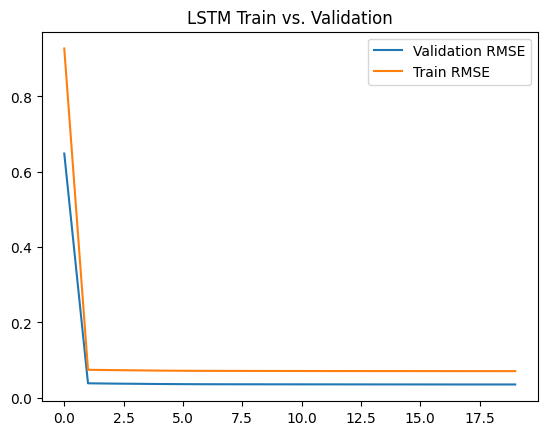

In [927]:
plt.plot(val_rmse, label='Validation RMSE')
plt.plot(train_rmse, label='Train RMSE')
plt.title("LSTM Train vs. Validation")
plt.legend()
plt.show()